In [59]:
# !pip install pycaret

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.clustering import *

# Data Preparation

In [61]:
# Import Dataset
df_Transaction = pd.read_csv("data/online_retail_II.csv")

# Change type Customer ID
df_Transaction["Customer ID"] = df_Transaction["Customer ID"]

# Print information of dataset
df_Transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [62]:
df_Transaction.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


## Handling missing value

Customer ID is our Identification feature and Description has Product description.

We cannot do RFM analysis and KMeans Clustering without Customer ID values.

Hence, droppingg the missing values

Negative Price = Free gift or Discount

In [63]:
# ก่อน drop NA ยังมี Price ติดลบอยู่
df_Transaction[["Quantity", "Price"]].describe()

,Quantity,Price
count,1.067371e+06,1.067371e+06
mean,9.938898e+00,4.649388e+00
std,1.727058e+02,1.235531e+02
min,-8.099500e+04,-5.359436e+04
25%,1.000000e+00,1.250000e+00
50%,3.000000e+00,2.100000e+00
75%,1.000000e+01,4.150000e+00
max,8.099500e+04,3.897000e+04


In [64]:
df_Transaction.shape

(1067371, 8)

In [65]:
# Check NA
df_Transaction.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [66]:
# Drop rows with missing values in the "Customer ID" column
# Customer ID = NA are not yet members
df_Transaction.dropna(subset=["Customer ID"],inplace=True)
df_Transaction.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [67]:
df_Transaction.shape

(824364, 8)

## Outlier handling -> Drop cancel transaction
Invoice numbers start with C and as per description of data these are cancellations hence dropping these entries

In [68]:
# After drop na negative prices are also dropped.

# Describe Before drop cancel transaction
df_Transaction[["Quantity", "Price"]].describe()

,Quantity,Price
count,824364.000000,824364.000000
mean,12.414574,3.676800
std,188.976099,70.241388
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [69]:
# drop cancel transaction
print(df_Transaction[df_Transaction["Invoice"].str.contains("C", na=False)]["Invoice"])
df_Transaction = df_Transaction[~df_Transaction["Invoice"].astype(str).str.contains("C", na=False)]

178        C489449
179        C489449
180        C489449
181        C489449
182        C489449
            ...   
1065910    C581490
1067002    C581499
1067176    C581568
1067177    C581569
1067178    C581569
Name: Invoice, Length: 18744, dtype: object


In [70]:
# After drop cancel transaction
# Negative Quantity are drop because Negative Quantity is Return/Refund Products
# Price = 0 is a Free gift
df_Transaction[["Quantity", "Price"]].describe()

,Quantity,Price
count,805620.000000,805620.000000
mean,13.307665,3.206279
std,144.306739,29.197901
min,1.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,10953.500000


In [71]:
df_Transaction.query("Price==0").head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.0,16126.0,United Kingdom
6781,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.0,15658.0,United Kingdom
16107,490727,M,Manual,1,2009-12-07 16:38:00,0.0,17231.0,United Kingdom
18738,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.0,14108.0,United Kingdom
18739,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.0,14108.0,United Kingdom


## Check Duplicates

Name changed for commercial benefits Make it easy for customers to search, causing stockcode and description to not be 1:1, causing database problems.

In [72]:
df_Transaction.shape

(805620, 8)

In [73]:
# Check Duplicates
# Invoice กับ InvoiceDate มีลักษณะ *ไม่เป็น 1:1*
print(df_Transaction.drop_duplicates(subset=["Customer ID", "Invoice", "InvoiceDate"]).shape)
print(df_Transaction.drop_duplicates(subset=["Customer ID", "Invoice"]).shape)

(37039, 8)
(36975, 8)


In [74]:
# Check Duplicates
# StockCode and Description are not *1:1 relationship*
print(df_Transaction.drop_duplicates(subset=["Customer ID", "Invoice", "InvoiceDate", "StockCode", "Description", "Quantity"]).shape)
print(df_Transaction.drop_duplicates(subset=["Customer ID", "Invoice", "InvoiceDate", "StockCode", "Quantity"]).shape)

(779459, 8)
(779457, 8)


# Feature Engineering

## Create Total Price column

In [75]:
# Create Total Price
df_Transaction["TotalPrice"] = df_Transaction["Quantity"] * df_Transaction["Price"]

# Sort columns
df_Transaction = df_Transaction[["Invoice", "InvoiceDate", "StockCode", "Description", "Quantity", "Price", "TotalPrice","Customer ID", "Country"]]

In [76]:
# Converting InvoiceDate to datetime. InvoiceDate is in format of 01-12-2010 08:26:33.
df_Transaction["InvoiceDate"] = pd.to_datetime(df_Transaction["InvoiceDate"], format="%Y-%m-%d %H:%M:%S")

# Create Date Time columns

In [77]:
# Extract the year from the "InvoiceDate" column and assign it to a new "year" column
df_Transaction["year"] = df_Transaction["InvoiceDate"].apply(lambda x: x.year)

# Extract the month number from the "InvoiceDate" column and assign it to a new "month_num" column
df_Transaction["month_num"] = df_Transaction["InvoiceDate"].apply(lambda x: x.month)

# Extract the day number from the "InvoiceDate" column and assign it to a new "day_num" column
df_Transaction["day_num"] = df_Transaction["InvoiceDate"].apply(lambda x: x.day)

# Extract the hour from the "InvoiceDate" column and assign it to a new "hour" column
df_Transaction["hour"] = df_Transaction["InvoiceDate"].apply(lambda x: x.hour)

# Extract the minute from the "InvoiceDate" column and assign it to a new "minute" column
df_Transaction["minute"] = df_Transaction["InvoiceDate"].apply(lambda x: x.minute)

# Extract the second from the "InvoiceDate" column and assign it to a new "second" column
df_Transaction["second"] = df_Transaction["InvoiceDate"].apply(lambda x: x.second)

In [78]:
# extracting month from the Invoice date
df_Transaction["Month"] = df_Transaction["InvoiceDate"].dt.month_name()

In [79]:
# extracting day from the Invoice date
df_Transaction["Day"] = df_Transaction["InvoiceDate"].dt.day_name()

In [80]:
df_Transaction.head(10)

,Invoice,InvoiceDate,StockCode,Description,Quantity,Price,TotalPrice,Customer ID,Country,year,month_num,day_num,hour,minute,second,Month,Day
0,489434,2009-12-01 07:45:00,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,83.4,13085.0,United Kingdom,2009,12,1,7,45,0,December,Tuesday
1,489434,2009-12-01 07:45:00,79323P,PINK CHERRY LIGHTS,12,6.75,81.0,13085.0,United Kingdom,2009,12,1,7,45,0,December,Tuesday
2,489434,2009-12-01 07:45:00,79323W,WHITE CHERRY LIGHTS,12,6.75,81.0,13085.0,United Kingdom,2009,12,1,7,45,0,December,Tuesday
3,489434,2009-12-01 07:45:00,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,100.8,13085.0,United Kingdom,2009,12,1,7,45,0,December,Tuesday
4,489434,2009-12-01 07:45:00,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,30.0,13085.0,United Kingdom,2009,12,1,7,45,0,December,Tuesday
5,489434,2009-12-01 07:45:00,22064,PINK DOUGHNUT TRINKET POT,24,1.65,39.6,13085.0,United Kingdom,2009,12,1,7,45,0,December,Tuesday
6,489434,2009-12-01 07:45:00,21871,SAVE THE PLANET MUG,24,1.25,30.0,13085.0,United Kingdom,2009,12,1,7,45,0,December,Tuesday
7,489434,2009-12-01 07:45:00,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,5.95,59.5,13085.0,United Kingdom,2009,12,1,7,45,0,December,Tuesday
8,489435,2009-12-01 07:46:00,22350,CAT BOWL,12,2.55,30.6,13085.0,United Kingdom,2009,12,1,7,46,0,December,Tuesday
9,489435,2009-12-01 07:46:00,22349,"DOG BOWL , CHASING BALL DESIGN",12,3.75,45.0,13085.0,United Kingdom,2009,12,1,7,46,0,December,Tuesday


# Exploratory Data Analysis

## Univariate Analysis

In [81]:
df_Transaction.columns

Index(['Invoice', 'InvoiceDate', 'StockCode', 'Description', 'Quantity',
       'Price', 'TotalPrice', 'Customer ID', 'Country', 'year', 'month_num',
       'day_num', 'hour', 'minute', 'second', 'Month', 'Day'],
      dtype='object')

In [82]:
df_Transaction.nunique()

Invoice        36975
InvoiceDate    34591
StockCode       4631
Description     5283
Quantity         438
Price            666
TotalPrice      3920
Customer ID     5881
Country           41
year               3
month_num         12
day_num           31
hour              15
minute            60
second             1
Month             12
Day                7
dtype: int64

In [83]:
df_Transaction[["Quantity", "Price", "TotalPrice"]].describe()

,Quantity,Price,TotalPrice
count,805620.000000,805620.000000,805620.000000
mean,13.307665,3.206279,22.024564
std,144.306739,29.197901,224.032150
min,1.000000,0.000000,0.000000
25%,2.000000,1.250000,4.950000
50%,5.000000,1.950000,11.850000
75%,12.000000,3.750000,19.500000
max,80995.000000,10953.500000,168469.600000


In [84]:
# Top 10 Country
eda2 = df_Transaction.drop_duplicates(subset=["Customer ID"]).groupby("Country")["Customer ID"].count().sort_values(ascending=False).reset_index().head(10)
eda2

,Country,Customer ID
0,United Kingdom,5352
1,Germany,107
2,France,93
3,Spain,39
4,Belgium,27
5,Portugal,24
6,Netherlands,22
7,Switzerland,21
8,Sweden,19
9,Italy,17


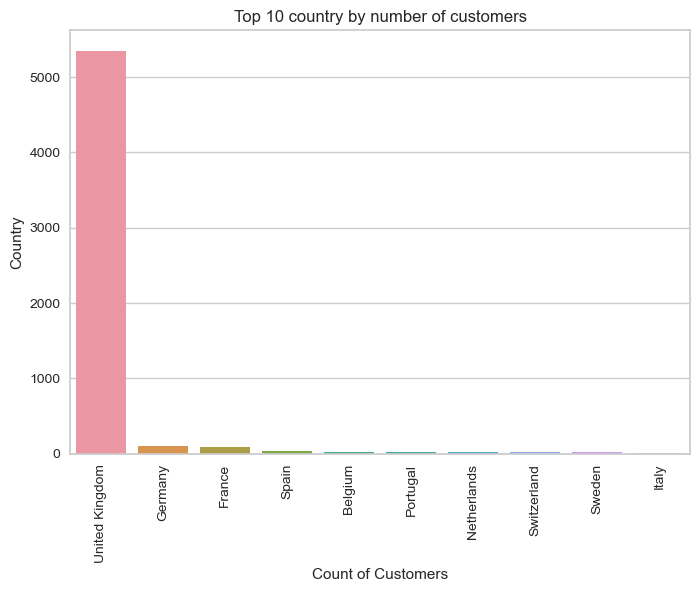

In [85]:
sns.barplot(x=eda2["Country"], y=eda2["Customer ID"])

plt.xlabel("Count of Customers")
plt.ylabel("Country")
plt.title("Top 10 country by number of customers")

plt.xticks(rotation = 90)

plt.show()

## Diagnostic Analytics

In [86]:
eda1 = df_Transaction.groupby("Description")["Quantity"].sum().sort_values(ascending=False).reset_index().head(10)
eda1

,Description,Quantity
0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,109169
1,WHITE HANGING HEART T-LIGHT HOLDER,93640
2,"PAPER CRAFT , LITTLE BIRDIE",80995
3,ASSORTED COLOUR BIRD ORNAMENT,79913
4,MEDIUM CERAMIC TOP STORAGE JAR,77916
5,JUMBO BAG RED RETROSPOT,75759
6,BROCADE RING PURSE,71129
7,PACK OF 60 PINK PAISLEY CAKE CASES,55270
8,60 TEATIME FAIRY CAKE CASES,53495
9,PACK OF 72 RETROSPOT CAKE CASES,46107


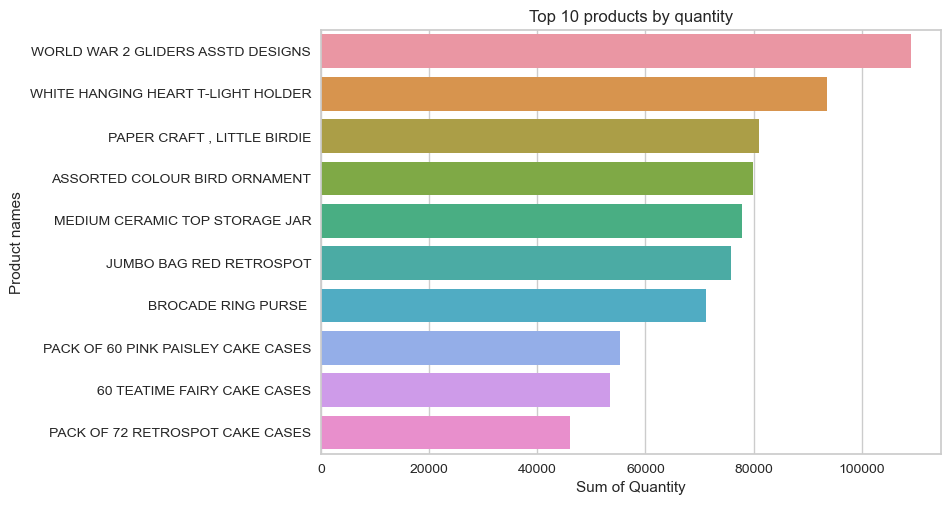

In [87]:
sns.barplot(x=eda1["Quantity"], y=eda1["Description"])

plt.xlabel("Sum of Quantity")
plt.ylabel("Product names")
plt.title("Top 10 products by quantity")

plt.show()

In [88]:
eda3 = df_Transaction.groupby('Month')['TotalPrice'].mean().reset_index().sort_values('TotalPrice',ascending=False)
eda3

,Month,TotalPrice
4,January,26.197724
11,September,23.910030
2,December,23.548217
1,August,23.397868
8,May,22.444622
6,June,22.274227
5,July,22.126397
3,February,22.022505
7,March,21.774235
0,April,21.326522


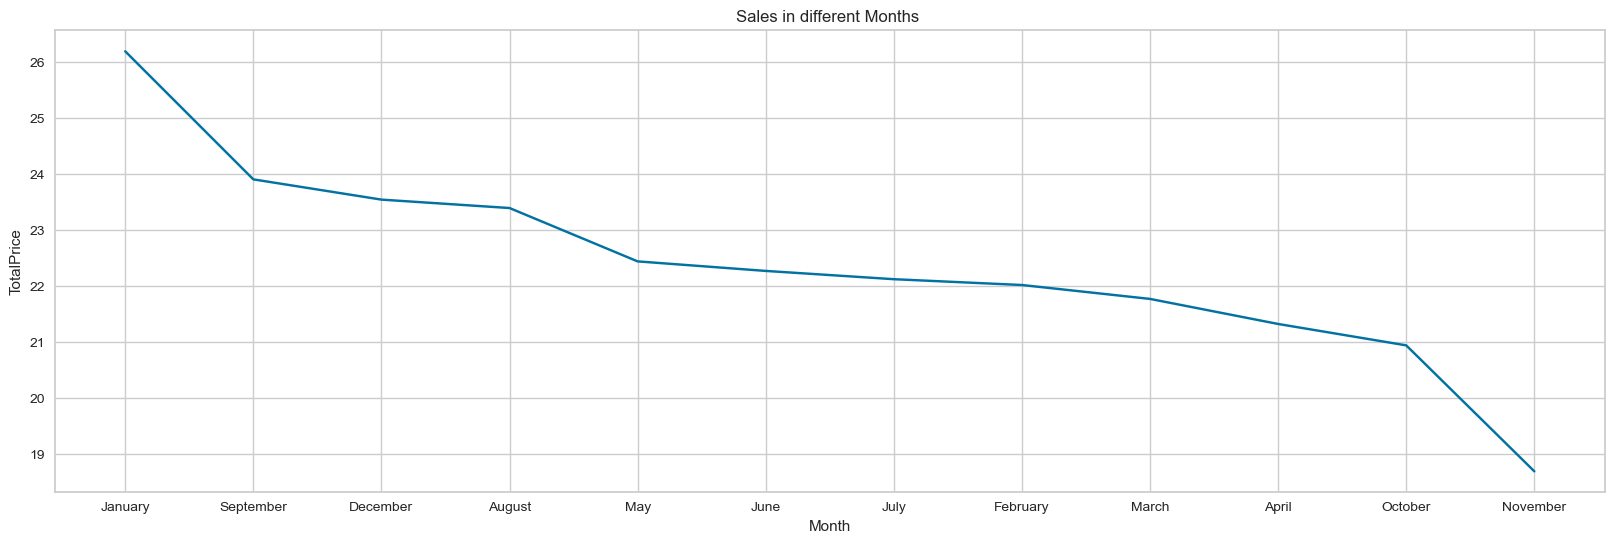

In [89]:
# Sales different months.
plt.figure(figsize=(20,6))
sns.lineplot(x = "Month",y = "TotalPrice", data = eda3)
plt.title('Sales in different Months ')
plt.show()

In [90]:
eda4 = df_Transaction.groupby('Day')['TotalPrice'].mean().reset_index().sort_values('TotalPrice',ascending=True)
eda4

,Day,TotalPrice
3,Sunday,13.323260
1,Monday,21.947727
6,Wednesday,22.824049
4,Thursday,23.755847
2,Saturday,24.507625
5,Tuesday,24.741623
0,Friday,26.141239


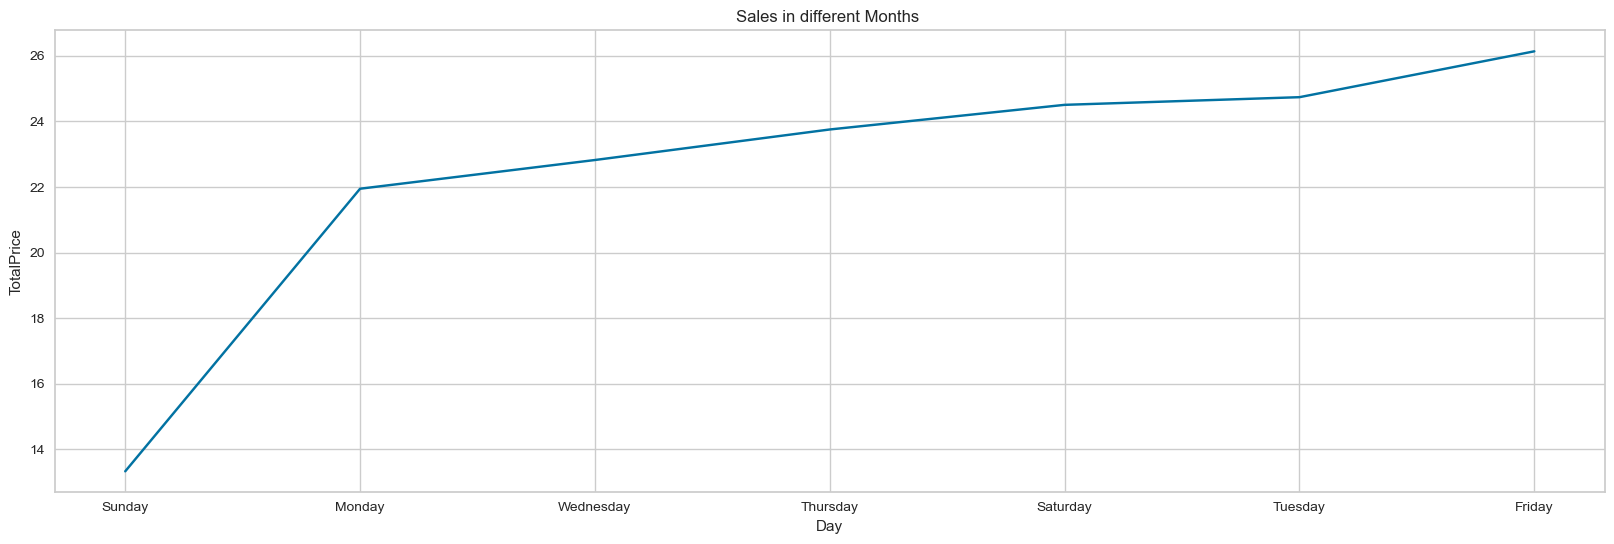

In [91]:
# Sales different months.
plt.figure(figsize=(20,6))
sns.lineplot(x = "Day",y = "TotalPrice", data = eda4)
plt.title('Sales in different Months ')
plt.show()

# RFM Analysis (Recency Frequency Monetary)

In [92]:
df_Transaction.columns

Index(['Invoice', 'InvoiceDate', 'StockCode', 'Description', 'Quantity',
       'Price', 'TotalPrice', 'Customer ID', 'Country', 'year', 'month_num',
       'day_num', 'hour', 'minute', 'second', 'Month', 'Day'],
      dtype='object')

In [93]:
# Convert the "InvoiceDate" column to datetime format
df_Transaction["InvoiceDate"] = pd.to_datetime(df_Transaction["InvoiceDate"])

# Calculate the maximum date from the joined_df DataFrame
max_date = df_Transaction["InvoiceDate"].max()

# Calculate the Recency by subtracting the maximum date for each Customer ID from the max_date
recency_df = df_Transaction.groupby("Customer ID")["InvoiceDate"].max().reset_index()
recency_df["Recency"] = (max_date - recency_df["InvoiceDate"]).dt.days

# Drop the unnecessary "InvoiceDate" column
recency_df.drop("InvoiceDate", axis=1, inplace=True)

# Calculate the Frequency and Monetary metrics as before
frequency_df = df_Transaction.groupby("Customer ID")["Invoice"].nunique().reset_index()
frequency_df.columns = ["Customer ID", "Frequency"]

monetary_df = df_Transaction.groupby("Customer ID")["TotalPrice"].sum().reset_index()
monetary_df.columns = ["Customer ID", "Monetary"]

# Merge the recency, frequency, and monetary DataFrames
rfm_df = pd.merge(recency_df, frequency_df, on="Customer ID")
rfm_df = pd.merge(rfm_df, monetary_df, on="Customer ID")

# Print the RFM DataFrame
rfm_df.head(10)

,Customer ID,Recency,Frequency,Monetary
0,12346.0,325,12,77556.46
1,12347.0,1,8,5633.32
2,12348.0,74,5,2019.40
3,12349.0,18,4,4428.69
4,12350.0,309,1,334.40
5,12351.0,374,1,300.93
6,12352.0,35,10,2849.84
7,12353.0,203,2,406.76
8,12354.0,231,1,1079.40
9,12355.0,213,2,947.61


In [94]:
data = rfm_df

s = setup(data,
          ignore_features = ["Customer ID"],
          session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(5881, 4)"
2,Transformed data shape,"(5881, 3)"
3,Ignore features,1
4,Numeric features,3
5,Preprocess,True
6,Imputation type,simple
7,Numeric imputation,mean
8,Categorical imputation,mode
9,CPU Jobs,-1


In [95]:
# from Elbow plot, k should be equal to 4.
kmeans = create_model("kmeans", num_clusters=4)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.9165,16838.8430,0.4182,0,0,0


In [96]:
print(kmeans)

KMeans(n_clusters=4, random_state=123)


In [97]:
evaluate_model(kmeans)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

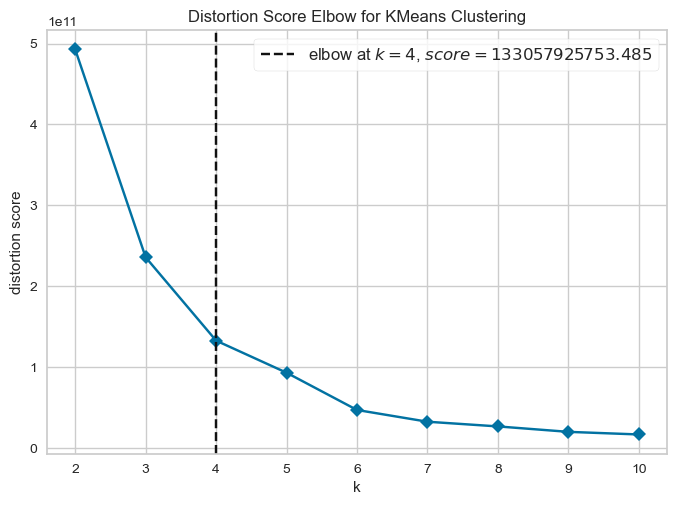

In [98]:
plot_model(kmeans, plot = "elbow")

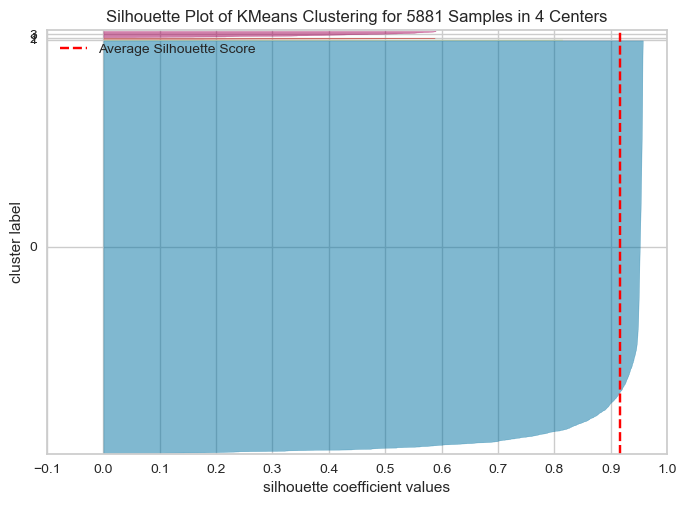

In [99]:
plot_model(kmeans, plot = "silhouette")

In [100]:
result = assign_model(kmeans)
result.head()

,Recency,Frequency,Monetary,Cluster
0,325,12,77556.460938,Cluster 3
1,1,8,5633.319824,Cluster 0
2,74,5,2019.400024,Cluster 0
3,18,4,4428.689941,Cluster 0
4,309,1,334.399994,Cluster 0


In [101]:
result = result.merge(rfm_df[["Customer ID"]], left_index=True, right_index=True)
result.head()

,Recency,Frequency,Monetary,Cluster,Customer ID
0,325,12,77556.460938,Cluster 3,12346.0
1,1,8,5633.319824,Cluster 0,12347.0
2,74,5,2019.400024,Cluster 0,12348.0
3,18,4,4428.689941,Cluster 0,12349.0
4,309,1,334.399994,Cluster 0,12350.0


In [102]:
cluster_counts = result['Cluster'].value_counts()
cluster_counts

Cluster
Cluster 0    5779
Cluster 3      87
Cluster 2      13
Cluster 1       2
Name: count, dtype: int64

In [103]:
summary = result.groupby("Cluster").mean()[["Recency", "Frequency", "Monetary"]]
summary

,Recency,Frequency,Monetary
Cluster,,,
Cluster 0,203.200554,5.325662,1911.773804
Cluster 1,0.500000,148.500000,568712.062500
Cluster 2,6.923077,127.384615,177016.671875
Cluster 3,51.781609,48.793103,37432.726562


In [104]:
alternative_names = {
    "Cluster 0": "Bronze",
    "Cluster 3": "Silver",
    "Cluster 2": "Gold",
    "Cluster 1": "Platinum"
}

In [105]:
result["Cluster"] = result["Cluster"].replace(alternative_names)
result

,Recency,Frequency,Monetary,Cluster,Customer ID
0,325,12,77556.460938,Silver,12346.0
1,1,8,5633.319824,Bronze,12347.0
2,74,5,2019.400024,Bronze,12348.0
3,18,4,4428.689941,Bronze,12349.0
4,309,1,334.399994,Bronze,12350.0
...,...,...,...,...,...
5876,3,22,2736.649902,Bronze,18283.0
5877,431,1,461.679993,Bronze,18284.0
5878,660,1,427.000000,Bronze,18285.0
5879,476,2,1296.430054,Bronze,18286.0


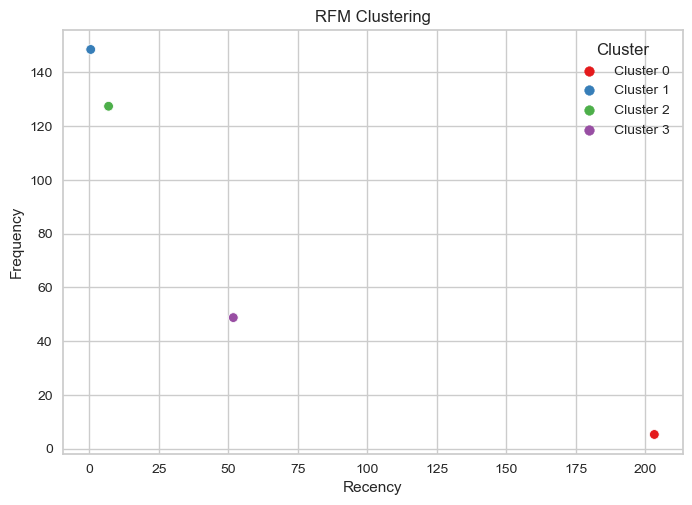

In [106]:
# Create a scatter plot with 'TransactionCount' on the x-axis, 'TotalRevenue' on the y-axis, and hue='Cluster' for the legend
sns.scatterplot(x="Recency", y="Frequency", hue='Cluster', data=summary, palette="Set1")

# Set labels and title
plt.xlabel("Recency")
plt.ylabel("Frequency")
plt.title("RFM Clustering")

# Show the plot
plt.show()

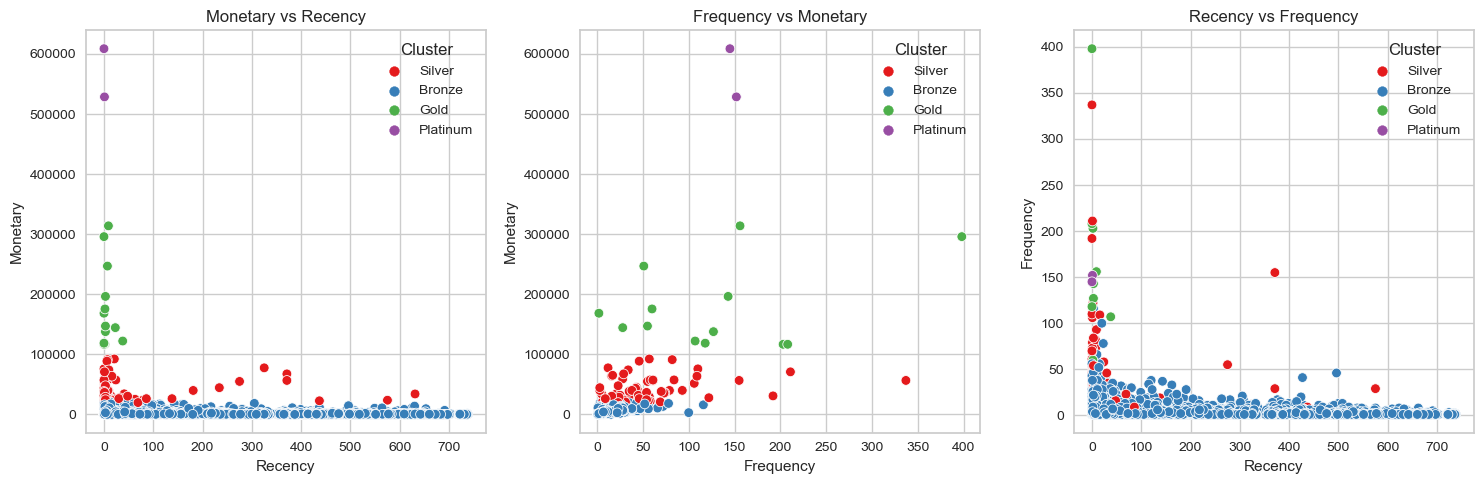

In [107]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

sns.scatterplot(data=result, x="Recency", y="Monetary", hue="Cluster", palette="Set1", ax=axes[0])
axes[0].set_title("Monetary vs Recency")
axes[0].set_xlabel("Recency")
axes[0].set_ylabel("Monetary")

sns.scatterplot(data=result, x="Frequency", y="Monetary", hue="Cluster", palette="Set1", ax=axes[1])
axes[1].set_title("Frequency vs Monetary")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Monetary")

sns.scatterplot(data=result, x="Recency", y="Frequency", hue="Cluster", palette="Set1", ax=axes[2])
axes[2].set_title("Recency vs Frequency")
axes[2].set_xlabel("Recency")
axes[2].set_ylabel("Frequency")

plt.tight_layout()

plt.show()

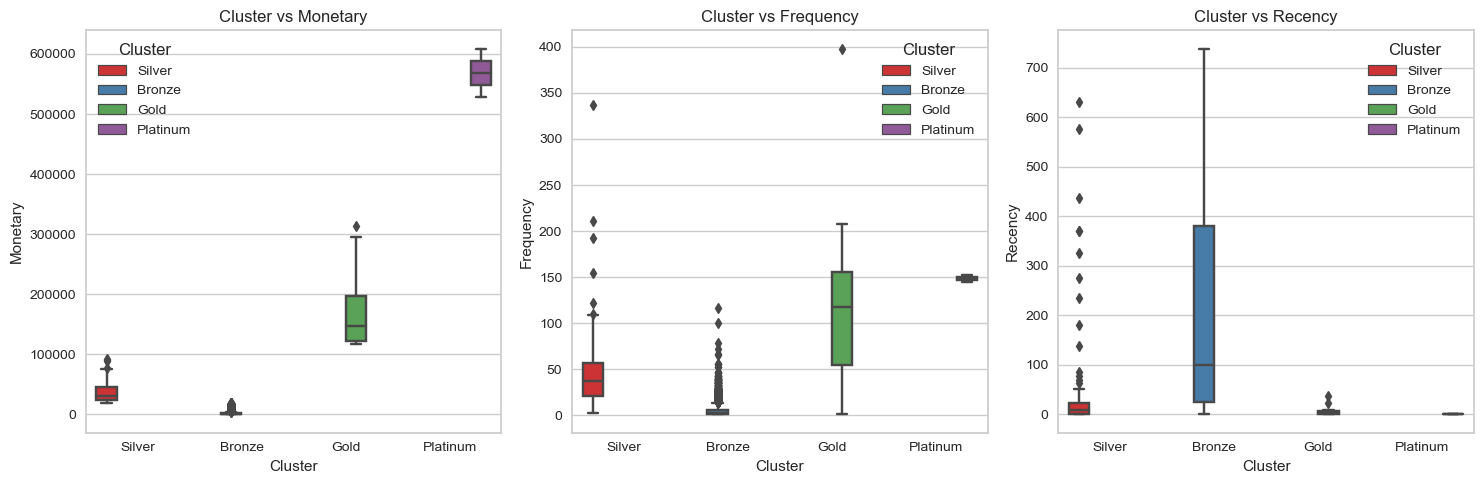

In [108]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# Box plot : Cluster vs. Monetary
sns.boxplot(data=result, x="Cluster", y="Monetary", hue="Cluster", palette="Set1", ax=axes[0])
axes[0].set_title("Cluster vs Monetary")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Monetary")

sns.boxplot(data=result, x="Cluster", y="Frequency", hue="Cluster", palette="Set1", ax=axes[1])
axes[1].set_title("Cluster vs Frequency")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Frequency")

sns.boxplot(data=result, x="Cluster", y="Recency", hue="Cluster", palette="Set1", ax=axes[2])
axes[2].set_title("Cluster vs Recency")
axes[2].set_xlabel("Cluster")
axes[2].set_ylabel("Recency")

plt.tight_layout()

plt.show()